### Notebook for the integration using ```scVI``` and clustering evaluation with ```SCCAF``` for Healthy PBMCs

**Objective**: Integration of healthy PBMCs from Cai 2020 {https://pubmed.ncbi.nlm.nih.gov/32114394/} and Yoshida 2021 {https://www.nature.com/articles/s41591-021-01329-2#data-availability}. 

**Developed by**: Mairi McClean

**Institute of Computational Biology - Helmholtz Zentrum Munich**

**v230425**


In [1]:
# Sanity check
import os 
os.write(1, b"text\n")

text


5

### Import required modules

In [2]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import ipywidgets as ipw

import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_sccaf_py39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

### Read in datasets for integration


- Read in _Cai Y et al 2020_

In [4]:
caiy2020 = sc.read_h5ad('../data/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [5]:
caiy2020.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

In [6]:
caiy_healthy = caiy2020[caiy2020.obs['status'].isin(['Healthy'])]
caiy_healthy

View of AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [7]:
caiy_healthy.obs['status'].value_counts()

status
Healthy    22049
Name: count, dtype: int64

- Read in _Yoshida et al 2021_

In [8]:
adata_yoshida = sc.read_h5ad('../data/meyer_nikolic_covid_pbmc.cellxgene.20210813.h5ad')
adata_yoshida

AnnData object with n_obs × n_vars = 422220 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [9]:
adata_yoshida.obs['COVID_status'].value_counts()

COVID_status
Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: count, dtype: int64

- Subset healthy Yoshida data 

In [10]:
yoshida_healthy = adata_yoshida[adata_yoshida.obs['COVID_status'].isin(['Healthy'])]
yoshida_healthy

View of AnnData object with n_obs × n_vars = 173684 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [11]:
yoshida_healthy.obs['COVID_status'].value_counts()

COVID_status
Healthy    173684
Name: count, dtype: int64

In [12]:
yoshida_healthy.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1,NP32,EUR,24.7,T CD8+,T CD8 naive,T CD8 naive,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.343914
S22_TTTGTCAGTGTAAGTA-1,NP32,EUR,24.7,NK,NK IFN stim,NK IFN stim,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.264285
S22_TTTGTCATCATGTCCC-1,NP31,AFR,18.2,Monocyte,Monocyte CD14,Classical monocyte,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.353094
S22_TTTGTCATCGAGGTAG-1,NP31,AFR,18.2,T CD8+,T CD8 naive,T CD8 naive,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.611991


In [13]:
yoshida_healthy.obs['patient_id'].value_counts()

patient_id
NP18    9799
NP13    8945
AN13    8244
NP23    8038
NP24    7376
AN12    7219
AN7     7105
NP19    7050
NP28    6894
NP17    6377
NP39    6115
AN2     5973
NP44    5906
NP36    5891
NP22    5535
NP27    5300
NP31    5029
NP21    4833
NP37    4654
AN6     4296
AN9     4150
AN5     3943
NP30    3916
NP41    3898
NP32    3778
NP15    3701
NP26    3539
NP20    3374
NP38    3218
AN14    2260
NP16    1851
AN11    1847
NP35    1674
AN3     1041
AN1      915
Name: count, dtype: int64

In [14]:
yoshida_healthy.obs['sample_id'].value_counts()

sample_id
NP18    9799
NP13    8945
AN13    8244
NP23    8038
NP24    7376
AN12    7219
AN7     7105
NP19    7050
NP28    6894
NP17    6377
NP39    6115
AN2     5973
NP44    5906
NP36    5891
NP22    5535
NP27    5300
NP31    5029
NP21    4833
NP37    4654
AN6     4296
AN9     4150
AN5     3943
NP30    3916
NP41    3898
NP32    3778
NP15    3701
NP26    3539
NP20    3374
NP38    3218
AN14    2260
NP16    1851
AN11    1847
NP35    1674
AN3     1041
AN1      915
Name: count, dtype: int64

- Rename shared column headers

In [15]:
yoshida_healthy.obs.rename(columns={"patient_id": "donor"}, inplace=True)

In [16]:
yoshida_healthy.obs

,donor,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1,NP32,EUR,24.7,T CD8+,T CD8 naive,T CD8 naive,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.343914
S22_TTTGTCAGTGTAAGTA-1,NP32,EUR,24.7,NK,NK IFN stim,NK IFN stim,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.264285
S22_TTTGTCATCATGTCCC-1,NP31,AFR,18.2,Monocyte,Monocyte CD14,Classical monocyte,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.353094
S22_TTTGTCATCGAGGTAG-1,NP31,AFR,18.2,T CD8+,T CD8 naive,T CD8 naive,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.611991


In [17]:
yoshida_healthy.obs['tissue'] = 'PBMC'

In [18]:
yoshida_healthy.obs

,donor,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight,tissue
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517,PBMC
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522,PBMC
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143,PBMC
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563,PBMC
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174,PBMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1,NP32,EUR,24.7,T CD8+,T CD8 naive,T CD8 naive,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.343914,PBMC
S22_TTTGTCAGTGTAAGTA-1,NP32,EUR,24.7,NK,NK IFN stim,NK IFN stim,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.264285,PBMC
S22_TTTGTCATCATGTCCC-1,NP31,AFR,18.2,Monocyte,Monocyte CD14,Classical monocyte,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.353094,PBMC
S22_TTTGTCATCGAGGTAG-1,NP31,AFR,18.2,T CD8+,T CD8 naive,T CD8 naive,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.611991,PBMC


- Merge _Cai_ and _Yoshida_ data

In [19]:
adata_healthy = caiy_healthy.concatenate(yoshida_healthy, batch_key = 'dataset', batch_categories = ['caiy2020', 'yoshida2021'], join = 'inner')
adata_healthy

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021'

In [20]:
adata_healthy.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight,dataset
AAACCTGAGATGGCGT-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2020
AAACCTGAGATGTGTA-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2020
AAACCTGAGCAACGGT-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2020
AAACCTGAGCCATCGC-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2020
AAACCTGAGGTGATTA-H2-caiy2020,CaiY_2021,SAMN14048020,PBMC_HC_2,PBMC,SAMN14048020,30,male,Healthy,scRNAseq,Shenzhen University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caiy2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22_TTTGTCAGTCGCATCG-1-yoshida2021,NaN,NaN,NaN,PBMC,NP32,NaN,NaN,NaN,NaN,NaN,...,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.343914,yoshida2021
S22_TTTGTCAGTGTAAGTA-1-yoshida2021,NaN,NaN,NaN,PBMC,NP32,NaN,NaN,NaN,NaN,NaN,...,Adolescent,Healthy,Healthy,Paediatric,Male,Non-smoker,NP32,CV001_KM9166642-CV001_KM9166650,0.264285,yoshida2021
S22_TTTGTCATCATGTCCC-1-yoshida2021,NaN,NaN,NaN,PBMC,NP31,NaN,NaN,NaN,NaN,NaN,...,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.353094,yoshida2021
S22_TTTGTCATCGAGGTAG-1-yoshida2021,NaN,NaN,NaN,PBMC,NP31,NaN,NaN,NaN,NaN,NaN,...,Child,Healthy,Healthy,Paediatric,Male,Non-smoker,NP31,CV001_KM9166642-CV001_KM9166650,0.611991,yoshida2021


### Harmonized dataset labels

In [21]:
# check tissue
adata_healthy.obs['tissue'].value_counts()

tissue
PBMC    195733
Name: count, dtype: int64

In [22]:
# Check donor
adata_healthy.obs['donor'].value_counts()

donor
SAMN14048019    11275
SAMN14048020    10774
NP18             9799
NP13             8945
AN13             8244
NP23             8038
NP24             7376
AN12             7219
AN7              7105
NP19             7050
NP28             6894
NP17             6377
NP39             6115
AN2              5973
NP44             5906
NP36             5891
NP22             5535
NP27             5300
NP31             5029
NP21             4833
NP37             4654
AN6              4296
AN9              4150
AN5              3943
NP30             3916
NP41             3898
NP32             3778
NP15             3701
NP26             3539
NP20             3374
NP38             3218
AN14             2260
NP16             1851
AN11             1847
NP35             1674
AN3              1041
AN1               915
Name: count, dtype: int64

### Calculate HVGs

- So the concatenated object doesn't have a counts layer (The original Cai object did, but Yoshida did not). Should I make a new layer in the original object and use that for the HVG and scVI model?

In [25]:
adata_raw = adata_healthy.copy()
adata_healthy.layers['counts'] = adata_healthy.X.copy()


In [26]:

sc.pp.highly_variable_genes(adata_healthy,
    flavor = "seurat_v3", 
    n_top_genes = 3000, 
    layer = "counts", 
    batch_key = "donor", 
    subset = True
)

adata_healthy

AnnData object with n_obs × n_vars = 195733 × 3000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

#### Remove unrequired variables prior to model run

In [27]:
del caiy2020
del adata_yoshida

### Integration with scVI


In [28]:
# From Carlos; "What is the main batch driver of the data?"

scvi.model.SCVI.setup_anndata(adata_healthy, layer="counts", batch_key="donor")

In [29]:
vae = scvi.model.SCVI(adata_healthy, n_layers=3, n_latent=50, gene_likelihood="nb", dispersion="gene-batch")

In [30]:
scvi.model.SCVI.view_anndata_setup(vae)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'donor',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   37   │
│         n_cells          │ 195733 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │     AN1      │          0          │
│                    │     AN2      │          1          │
│                    │     AN3      │          2          │
│                    │     AN5      │          3          │
│                    │     AN6      │          4          │
│                    │     AN7      │          5          │
│                    │     AN9      │          6          │
│                    │     AN11     │          7          │
│                    │     AN12     │          8          │
│                    │     AN13     │          9          │
│                    │     AN14     │         10          │
│                    │     NP13     │         11          │
│                    │     NP15     │         12          │
│                    │     NP16     │         13          │
│                    │     NP17     │         14          │
│                    │     NP18     │         15          │
│                    │     NP19     │         16          │
│                    │     NP20     │         17          │
│                    │     NP21     │         18          │
│                    │     NP22     │         19          │
│                    │     NP23     │         20          │
│                    │     NP24     │         21          │
│                    │     NP26     │         22          │
│                    │     NP27     │         23          │
│                    │     NP28     │         24          │
│                    │     NP30     │         25          │
│                    │     NP31     │         26          │
│                    │     NP32     │         27          │
│                    │     NP35     │         28          │
│                    │     NP36     │         29          │
│                    │     NP37     │         30          │
│                    │     NP38     │         31          │
│                    │     NP39     │         32          │
│                    │     NP41     │         33          │
│                    │     NP44     │         34          │
│                    │ SAMN14048019 │         35          │
│                    │ SAMN14048020 │         36          │
└────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [31]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 41/41: 100%|██████████| 41/41 [48:58<00:00, 72.22s/it, loss=957, v_num=1]   

`Trainer.fit` stopped: `max_epochs=41` reached.


Epoch 41/41: 100%|██████████| 41/41 [48:58<00:00, 71.68s/it, loss=957, v_num=1]


In [32]:
adata_healthy.obsm["X_scVI"] = vae.get_latent_representation()

In [33]:
# Add random state command for neighbors and leiden

sc.pp.neighbors(adata_healthy, n_neighbors=50, use_rep="X_scVI", random_state=30, metric = 'minkowski')
sc.tl.umap(adata_healthy, min_dist=0.5, spread=8, random_state=30)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [34]:
plt.figure(figsize = (5, 5))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

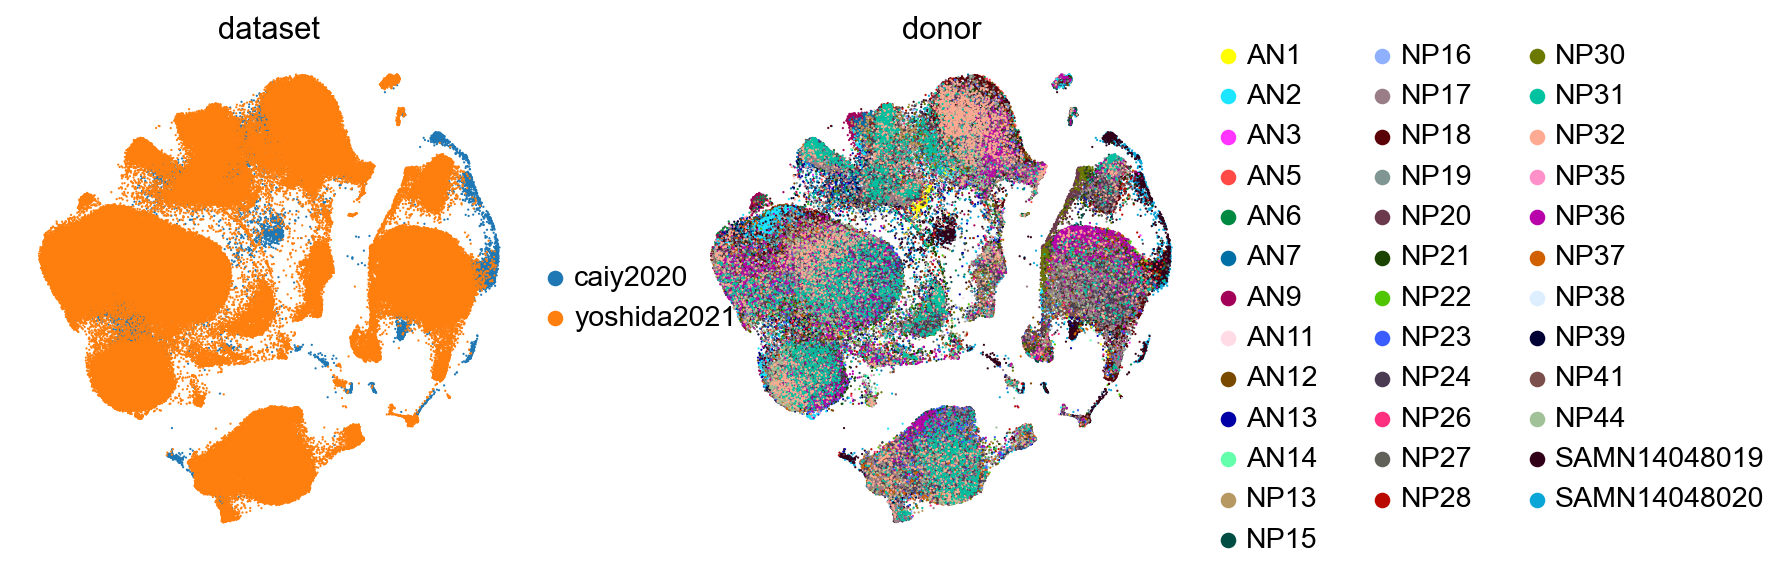

In [35]:
# Variables chosen as they are those shared by both datasets

sc.pl.umap(
    adata_healthy,
    color=["dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


### SCCAF clustering analysis

In [36]:
import SCCAF as sccaf
from SCCAF import SCCAF_assessment, plot_roc

In [37]:
# Resolution on a scale from 0 to 1

sc.tl.leiden(adata_healthy, resolution = 1.0, random_state = 1786)

In [38]:

y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_healthy.X, adata_healthy.obs['leiden'], n = 100)



Mean CV accuracy: 0.8735
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8379


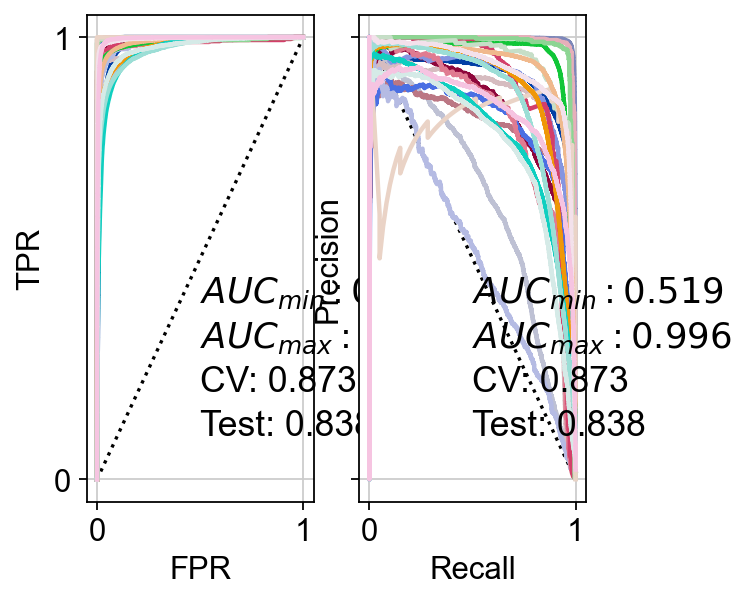

In [39]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

plt.show()

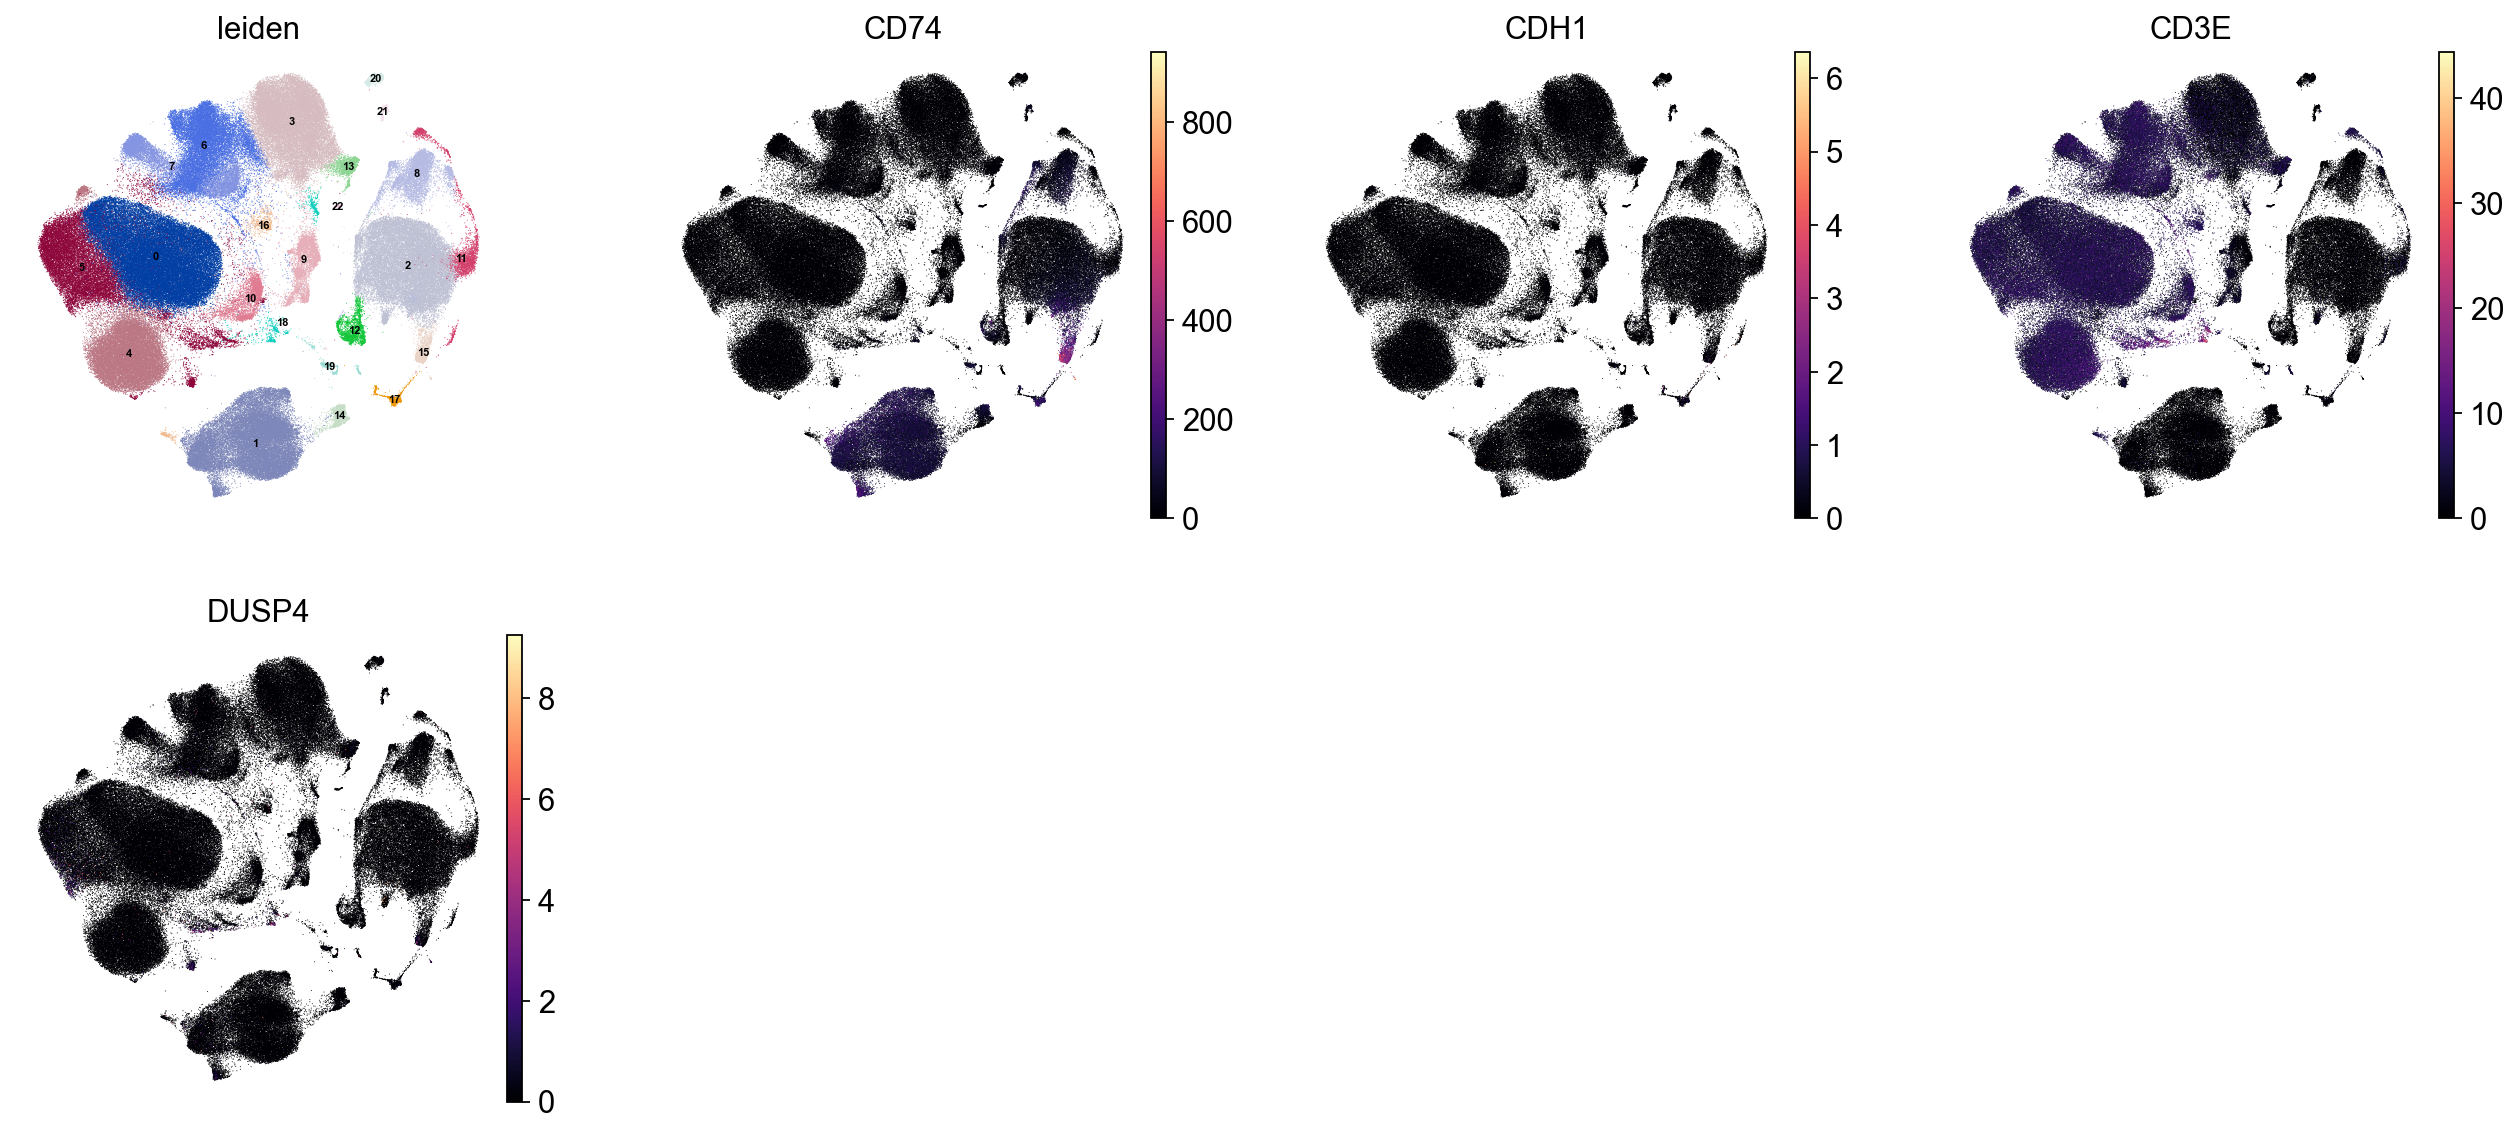

In [40]:
# Markers chosen here are of interest in healthy blood cells



sc.pl.umap(adata_healthy, frameon = False, color = ['leiden', 'CD74', 'CDH1', 'CD3E', 'DUSP4'], size = 0.8, legend_fontsize = 5, legend_loc = 'on data', color_map="magma")

### Export clustered object

In [41]:
adata_raw

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021'

In [42]:
adata_healthy

AnnData object with n_obs × n_vars = 195733 × 3000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    

In [43]:
# Making a hybrid anndata object using sections from both original anndata object and the cai_tb_gex object
adata_export = anndata.AnnData(X = adata_healthy.X, var = adata_healthy.var, obs = adata_raw.obs, uns = adata_raw.uns, obsm = adata_raw.obsm, layers = adata_healthy.layers, obsp = adata_raw.obsp)
adata_export

AnnData object with n_obs × n_vars = 195733 × 3000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    layers: 'counts'

In [44]:
adata_export.write('../CaiY_Yoshida_healthy_scRNA_PBMC_mm230426_scVI-clustered.raw.h5ad')
